In [1]:
import pandas as pd
import sys, os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from crimebb import *

In [3]:
# !pip install nltk

In [4]:
# !pip install wordcloud

In [5]:
# !pip install pycountry

In [6]:
# !pip install multidict

In [7]:
YEAR="2021"

In [8]:
DATA_PATH="../data/"
CSV_PATH = f"{DATA_PATH}csv/{YEAR}/"

In [9]:
language_to_eval = ["russian", "english", "german"]

### Loading data

#### boards

In [10]:
boards_df = pd.read_csv(f"{CSV_PATH}boards.csv", sep="\t", low_memory=False)
boards_df["url"] = boards_df["url"].apply(lambda x: x.replace("antichat.com", "forum.antichat.ru"))
boards_df["site_name"] = boards_df["url"].apply(lambda x: (x.replace("https://", "")).split("/")[0] if "https" in x else (x.replace("http://", "")).split("/")[0] )
boards_df.drop_duplicates(inplace=True)
boards_df = boards_df[["id", "site_id", "site_name", "name", "url"]].copy().drop_duplicates()
boards_df.rename(columns={"id":"board_id", "name":"board_title", "url":"board_url"}, inplace=True)
boards_df

,board_id,site_id,site_name,board_title,board_url
0,24,10,forum.antichat.ru,"С/С++, C#, Delphi, .NET, Asm",https://forum.antichat.ru/forums/24/page-356
1,145,10,forum.antichat.ru,Хостинги - Hostings,https://forum.antichat.ru/forumdisplay.php?f=1...
2,150,10,forum.antichat.ru,"Мобильная связь, СМС - Покупка, продажа",https://forum.antichat.ru/forums/150/page-266
3,157,10,forum.antichat.ru,"Услуги, Покупка и Продажа в SEO",https://forum.antichat.ru/link-forums/157/page-2
4,30,10,forum.antichat.ru,Статьи,https://forum.antichat.ru/forumdisplay.php?f=3...
...,...,...,...,...,...
893,32,20,torum6uvof666pzw.onion,Networking / Wireless,http://torum6uvof666pzw.onion/viewforum.php?f=...
894,24,20,torum6uvof666pzw.onion,Website Pentesting,http://torum6uvof666pzw.onion/viewforum.php?f=...
895,29,20,torum6uvof666pzw.onion,Operating Systems,http://torum6uvof666pzw.onion/viewforum.php?f=...
896,60,20,torum6uvof666pzw.onion,Challenges,http://torum6uvof666pzw.onion/viewforum.php?f=...


#### website

In [11]:
website_df = boards_df[["site_name", "site_id"]].copy()
website_df.drop_duplicates(inplace=True)
website_df

,site_name,site_id
0,forum.antichat.ru,10
64,germanyruvvy2tcw.onion,23
107,dreadditevelidot.onion,19
553,envoys5appps3bin.onion,21
646,garage4hackers.com,7
681,raidforums.com,12
756,lwplxqzvmgu43uff.onion,24
775,www.safeskyhacks.com,13
825,thehub7xbw4dc5r2.onion,2
887,torum6uvof666pzw.onion,20


#### Threads

In [12]:
threads_df = pd.read_csv(f"{CSV_PATH}threads.csv", sep="\t", low_memory=False)
threads_df["url"] = threads_df["url"].apply(lambda x: x.replace("antichat.com", "forum.antichat.ru"))
threads_df.drop_duplicates(inplace=True)
threads_df = threads_df[["id", "site_id", "board_id", "creator", "creator_id", "name", "url", "created_on"]].copy().drop_duplicates()
threads_df.rename(columns={"creator":"username", "id":"thread_id", "creator_id":"user_id", "name":"thread_title", "url":"thread_url", "created_on": "thread_data_creation"}, inplace=True)
#threads_df = threads_df[ (threads_df["username"].str.lower()!="none") & (~threads_df["username"].isna()) ].copy().drop_duplicates()
threads_df

,thread_id,site_id,board_id,username,user_id,thread_title,thread_url,thread_data_creation
0,473570,10,23,dbagrov,342815,ФСБ видит угрозу в защищённых мессенджерах и а...,https://forum.antichat.ru/threads/473570/,2019-10-24 12:09:03.149923-03
1,472702,10,23,Dark_shadow,335846,Эксперт Google: Вредоносные сайты атаковали по...,https://forum.antichat.ru/threads/472702/,2019-10-24 12:09:29.163386-03
2,473412,10,23,littlebig000,327300,Ирак полностью отключил интернет в стране,https://forum.antichat.ru/threads/473412/,2019-10-24 12:09:05.359046-03
3,472675,10,23,Alienplan,335505,[ВОЗМОЖНО] СОРМ расшифровывает HTTPS трафик к ...,https://forum.antichat.ru/threads/472675/,2019-10-24 12:09:29.64036-03
4,473059,10,23,010101Hex,327986,Обвиняемый во взломе JP Morgan Chase россиянин...,https://forum.antichat.ru/threads/473059/,2019-10-24 12:09:18.955105-03
...,...,...,...,...,...,...,...,...
405178,4450,20,62,variable6754,11470,Working dark net market places,http://torum6uvof666pzw.onion/viewtopic.php?f=...,2019-08-07 12:07:39.79638-03
405179,4495,20,62,WrecklessRush,10707,Need Empire market mirror link,http://torum6uvof666pzw.onion/viewtopic.php?f=...,2019-08-07 12:07:16.971569-03
405180,4182,20,62,8634534634543,10256,Discovering A Legitimate Online Hacking Service,http://torum6uvof666pzw.onion/viewtopic.php?f=...,2019-08-07 12:09:41.136812-03
405181,3848,20,62,AXDZ,9220,best market,http://torum6uvof666pzw.onion/viewtopic.php?f=...,2019-08-07 12:09:52.858637-03


#### posts

In [13]:
posts_df = pd.read_csv(f"{CSV_PATH}posts.csv", sep="\t", low_memory=False)
posts_df.drop_duplicates(inplace=True)
posts_df = posts_df[["id", "site_id", "board_id", "thread_id", "creator", "creator_id", "creator_n_posts", "creator_reputation", "content", "quoted_post_ids", "created_on"]].copy().drop_duplicates()
posts_df.rename(columns={"creator":"username", "id":"post_id", "creator_id":"user_id", "creator_n_posts":"user_num_posts", "creator_reputation":"user_reputation", "created_on": "post_data_creation"}, inplace=True)
#posts_df = posts_df[ (posts_df["username"].str.lower()!="none") & (~posts_df["username"].isna()) ].copy().drop_duplicates()
posts_df = posts_df[~posts_df["content"].isna()].copy().drop_duplicates()
posts_df

,post_id,site_id,board_id,thread_id,username,user_id,user_num_posts,user_reputation,content,quoted_post_ids,post_data_creation
0,34,10,114,9,Algol,1174,1761,0,Адрес хоть дай...Первый раз слышу о таком ...,{},2002-05-31 06:36:00-03
1,637,10,114,113,Algol,1174,1761,0,Кстати этот чат ломается ...,{},2002-08-05 16:15:00-03
2,710,10,114,137,Algol,1174,1761,0,Чесно говоря это действительно большая редкост...,{},2002-08-12 08:08:00-03
3,491,10,114,99,GPT cd-r74xl 24x,1548,1,0,"Сорри, этт я неправильно указал ихний адрес. И...",{},2002-07-19 09:30:00-03
4,571,10,46,120,iRedX,1968,123,9,Скоро будет обновление,{},2002-07-31 23:01:00-03
...,...,...,...,...,...,...,...,...,...,...,...
3373784,42116,20,49,8611,tolerance2,24965,14,0,What is that? I dont have javascript enabled s...,{},2019-08-06 21:00:00-03
3373785,42124,20,62,8454,mrkcuf,22583,52,0,***LINK***lovelycloud[./memberlist.php?mode=vi...,{},2019-08-06 21:00:00-03
3373786,42129,20,62,8454,rIA,15407,27,0,I wrote some keyloggers for android if you are...,{},2019-08-06 21:00:00-03
3373787,42134,20,62,8454,lovelycloud,25064,7,0,ok..,{},2019-08-06 21:00:00-03


#### posts x threads x boards x website

In [14]:
posts_website_df = pd.merge(posts_df, website_df, how="left", on="site_id")
posts_website_df

,post_id,site_id,board_id,thread_id,username,user_id,user_num_posts,user_reputation,content,quoted_post_ids,post_data_creation,site_name
0,34,10,114,9,Algol,1174,1761,0,Адрес хоть дай...Первый раз слышу о таком ...,{},2002-05-31 06:36:00-03,forum.antichat.ru
1,637,10,114,113,Algol,1174,1761,0,Кстати этот чат ломается ...,{},2002-08-05 16:15:00-03,forum.antichat.ru
2,710,10,114,137,Algol,1174,1761,0,Чесно говоря это действительно большая редкост...,{},2002-08-12 08:08:00-03,forum.antichat.ru
3,491,10,114,99,GPT cd-r74xl 24x,1548,1,0,"Сорри, этт я неправильно указал ихний адрес. И...",{},2002-07-19 09:30:00-03,forum.antichat.ru
4,571,10,46,120,iRedX,1968,123,9,Скоро будет обновление,{},2002-07-31 23:01:00-03,forum.antichat.ru
...,...,...,...,...,...,...,...,...,...,...,...,...
3369010,42116,20,49,8611,tolerance2,24965,14,0,What is that? I dont have javascript enabled s...,{},2019-08-06 21:00:00-03,torum6uvof666pzw.onion
3369011,42124,20,62,8454,mrkcuf,22583,52,0,***LINK***lovelycloud[./memberlist.php?mode=vi...,{},2019-08-06 21:00:00-03,torum6uvof666pzw.onion
3369012,42129,20,62,8454,rIA,15407,27,0,I wrote some keyloggers for android if you are...,{},2019-08-06 21:00:00-03,torum6uvof666pzw.onion
3369013,42134,20,62,8454,lovelycloud,25064,7,0,ok..,{},2019-08-06 21:00:00-03,torum6uvof666pzw.onion


In [15]:
posts_boards_df = pd.merge(posts_website_df, boards_df[["site_id", "board_id", "board_title"]].drop_duplicates(), on=["site_id", "board_id"], how="left")
posts_boards_df

,post_id,site_id,board_id,thread_id,username,user_id,user_num_posts,user_reputation,content,quoted_post_ids,post_data_creation,site_name,board_title
0,34,10,114,9,Algol,1174,1761,0,Адрес хоть дай...Первый раз слышу о таком ...,{},2002-05-31 06:36:00-03,forum.antichat.ru,Веб-уязвимости
1,637,10,114,113,Algol,1174,1761,0,Кстати этот чат ломается ...,{},2002-08-05 16:15:00-03,forum.antichat.ru,Веб-уязвимости
2,710,10,114,137,Algol,1174,1761,0,Чесно говоря это действительно большая редкост...,{},2002-08-12 08:08:00-03,forum.antichat.ru,Веб-уязвимости
3,491,10,114,99,GPT cd-r74xl 24x,1548,1,0,"Сорри, этт я неправильно указал ихний адрес. И...",{},2002-07-19 09:30:00-03,forum.antichat.ru,Веб-уязвимости
4,571,10,46,120,iRedX,1968,123,9,Скоро будет обновление,{},2002-07-31 23:01:00-03,forum.antichat.ru,Болталка
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3369010,42116,20,49,8611,tolerance2,24965,14,0,What is that? I dont have javascript enabled s...,{},2019-08-06 21:00:00-03,torum6uvof666pzw.onion,General Discussions
3369011,42124,20,62,8454,mrkcuf,22583,52,0,***LINK***lovelycloud[./memberlist.php?mode=vi...,{},2019-08-06 21:00:00-03,torum6uvof666pzw.onion,Marketplace Discussions
3369012,42129,20,62,8454,rIA,15407,27,0,I wrote some keyloggers for android if you are...,{},2019-08-06 21:00:00-03,torum6uvof666pzw.onion,Marketplace Discussions
3369013,42134,20,62,8454,lovelycloud,25064,7,0,ok..,{},2019-08-06 21:00:00-03,torum6uvof666pzw.onion,Marketplace Discussions


In [16]:
posts_threads_df = pd.merge(posts_boards_df, threads_df[["site_id", "board_id", "thread_id", "thread_title"]].drop_duplicates(), on=["site_id", "board_id", "thread_id"], how="left")
posts_threads_df

,post_id,site_id,board_id,thread_id,username,user_id,user_num_posts,user_reputation,content,quoted_post_ids,post_data_creation,site_name,board_title,thread_title
0,34,10,114,9,Algol,1174,1761,0,Адрес хоть дай...Первый раз слышу о таком ...,{},2002-05-31 06:36:00-03,forum.antichat.ru,Веб-уязвимости,ВЗЛОМ ФОРУМОВ
1,637,10,114,113,Algol,1174,1761,0,Кстати этот чат ломается ...,{},2002-08-05 16:15:00-03,forum.antichat.ru,Веб-уязвимости,Есть вопрос на счёт чата
2,710,10,114,137,Algol,1174,1761,0,Чесно говоря это действительно большая редкост...,{},2002-08-12 08:08:00-03,forum.antichat.ru,Веб-уязвимости,Клиенты для чата...
3,491,10,114,99,GPT cd-r74xl 24x,1548,1,0,"Сорри, этт я неправильно указал ихний адрес. И...",{},2002-07-19 09:30:00-03,forum.antichat.ru,Веб-уязвимости,Всевидящее Око на http://chat.userline.ru
4,571,10,46,120,iRedX,1968,123,9,Скоро будет обновление,{},2002-07-31 23:01:00-03,forum.antichat.ru,Болталка,Зацените сайт
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3369010,42116,20,49,8611,tolerance2,24965,14,0,What is that? I dont have javascript enabled s...,{},2019-08-06 21:00:00-03,torum6uvof666pzw.onion,General Discussions,Free stuff
3369011,42124,20,62,8454,mrkcuf,22583,52,0,***LINK***lovelycloud[./memberlist.php?mode=vi...,{},2019-08-06 21:00:00-03,torum6uvof666pzw.onion,Marketplace Discussions,KEYLOGGER
3369012,42129,20,62,8454,rIA,15407,27,0,I wrote some keyloggers for android if you are...,{},2019-08-06 21:00:00-03,torum6uvof666pzw.onion,Marketplace Discussions,KEYLOGGER
3369013,42134,20,62,8454,lovelycloud,25064,7,0,ok..,{},2019-08-06 21:00:00-03,torum6uvof666pzw.onion,Marketplace Discussions,KEYLOGGER


#### Pre-processing content

In [17]:
posts_threads_df["content_processed"] = posts_threads_df["content"].apply(lambda x: x.replace("https", "") )
posts_threads_df["content_processed"] = posts_threads_df["content_processed"].apply(lambda x: x.replace("http", "") )
posts_threads_df["content_processed"] = posts_threads_df["content_processed"].apply(lambda x: x.replace("...", "") )
posts_threads_df["content_processed"] = posts_threads_df["content_processed"].apply(lambda x: x.replace("..", "") )
posts_threads_df["content_processed"] = posts_threads_df["content_processed"].apply(lambda x: re.sub('[\\\'\"+@_!#$%^&*,;()<>?/\|\[\]}{~:=]', " ", x) )

#### Detecting languages

In [18]:
posts_threads_df["language_content"] = posts_threads_df["content_processed"].apply(lambda x: detect_language(str(x), language_to_eval=language_to_eval) )

In [19]:
posts_threads_df["language_detected"] = posts_threads_df["language_content"].apply(lambda x: max(x, key=x.get) )

In [20]:
posts_threads_df["language_score"] = posts_threads_df["language_content"].apply(lambda x: max(x.values() ))

In [21]:
posts_threads_df["language_detected"].unique()

array(['russian', 'english', 'german'], dtype=object)

In [22]:
posts_threads_df.to_csv(f"{CSV_PATH}post_thread_board.csv", sep='\t', index=False)

#### Languages

In [23]:
lang_post_df = posts_threads_df.pivot_table(columns=['language_detected'], aggfunc='size')
lang_post_df.sort_values(ascending=False, inplace=True)
lang_post_df

language_detected
russian    2616913
english     728250
german       23852
dtype: int64

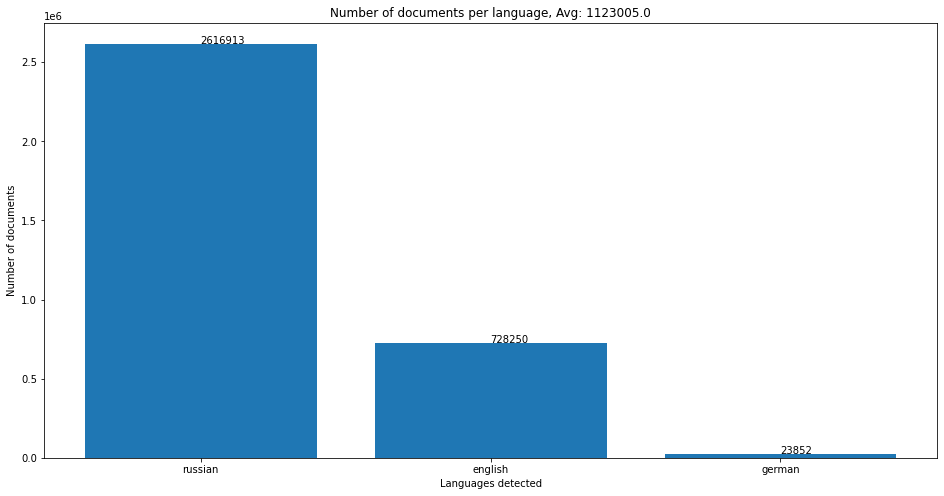

In [24]:
mean_val = round(lang_post_df.mean(), 2)

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lang_post_df.index.values, lang_post_df.values)

for x,y,p in zip(lang_post_df.index.values, lang_post_df.values, lang_post_df.values):
  plt.text(x, y, p)
plt.xlabel("Languages detected")
plt.ylabel("Number of documents")
plt.title(f"Number of documents per language, Avg: {mean_val}")
plt.show()

#### Wordclouds

In [25]:
english_df = posts_threads_df[posts_threads_df["language_detected"]=="english"].copy()
english_df["content_processed"] = english_df["content_processed"].apply(lambda x: re.sub('[0-9]+', "", x) )
english_content = ' '.join(english_df["content_processed"])

In [26]:
german_df = posts_threads_df[posts_threads_df["language_detected"]=="german"].copy()
german_df["content_processed"] = german_df["content_processed"].apply(lambda x: re.sub('[0-9]+', "", x) )
german_content = ' '.join(german_df["content_processed"])

In [27]:
russian_df = posts_threads_df[posts_threads_df["language_detected"]=="russian"].copy()
russian_df["content_processed"] = russian_df["content_processed"].apply(lambda x: re.sub('[0-9]+', "", x) )
russian_content = ' '.join(russian_df["content_processed"])

In [28]:
en_dict = getFrequencyDictForText(english_content, language_to_eval=language_to_eval)

In [29]:
german_dict = getFrequencyDictForText(german_content, language_to_eval=language_to_eval)

In [30]:
ru_dict = getFrequencyDictForText(russian_content, language_to_eval=language_to_eval)

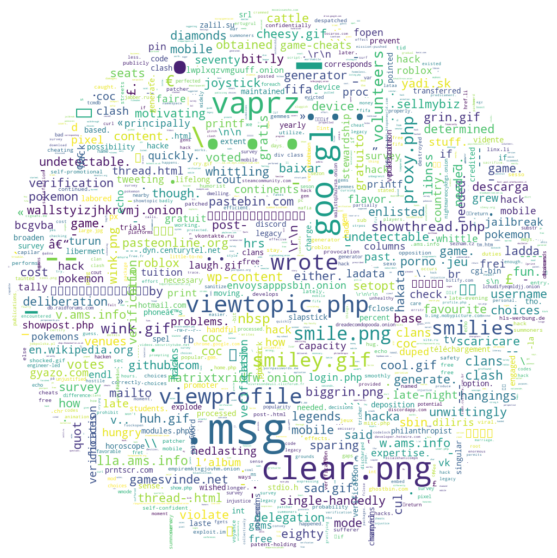

In [31]:
showWordCloud(en_dict)

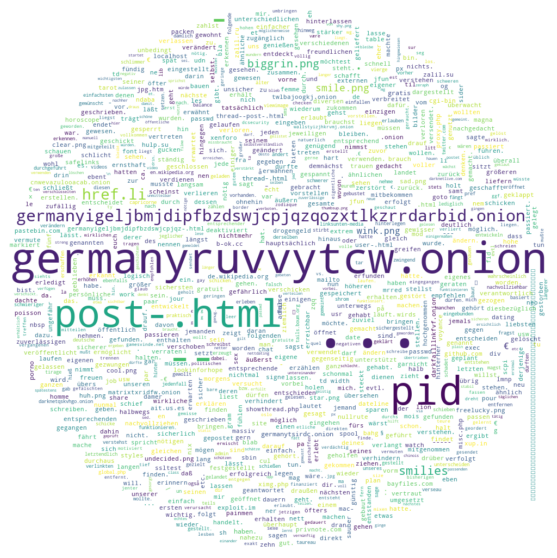

In [32]:
showWordCloud(german_dict)

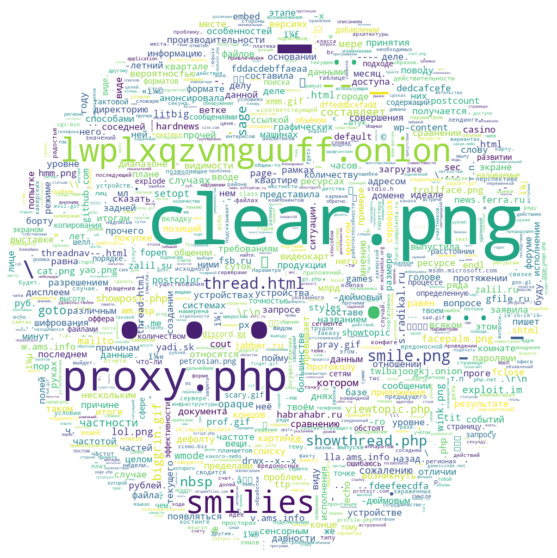

In [33]:
showWordCloud(ru_dict)